In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler

In [2]:
# Fungsi untuk menghitung metrik evaluasi
def calculate_metrics(y_true, y_pred):
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }
    return metrics

In [3]:
# Eksplorasi Data (EDA)
url = '/content/df_filtered_local.csv'
data = pd.read_csv(url)
data.rename(columns={data.columns[1]: 'CO2'}, inplace=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3617 entries, 0 to 3616
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           3617 non-null   object 
 1   CO2            3617 non-null   float64
 2   Tx             3617 non-null   float64
 3   Tavg           3617 non-null   float64
 4   RH_avg         3617 non-null   float64
 5   RR             3617 non-null   float64
 6   ss             3617 non-null   float64
 7   ff_x           3617 non-null   float64
 8   ddd_x          3617 non-null   float64
 9   ff_avg         3617 non-null   float64
 10  ddd_car        3617 non-null   object 
 11  station_id     3617 non-null   int64  
 12  station_name   3617 non-null   object 
 13  region_name    3617 non-null   object 
 14  latitude       3617 non-null   float64
 15  longitude      3617 non-null   float64
 16  region_id      3617 non-null   int64  
 17  province_id    3617 non-null   int64  
 18  province

In [4]:
data['date'] = pd.to_datetime(data['date'])
y = data["Tavg"]

In [5]:
# Analisis Statistik deskriptif Awal
print("\nStatistik deskriptif Awal:")
print(data.describe())


Statistik deskriptif Awal:
                                date          CO2           Tx         Tavg  \
count                           3617  3617.000000  3617.000000  3617.000000   
mean   2015-08-22 16:46:02.952723200    23.594802    33.389052    27.599309   
min              2010-01-01 00:00:00    17.000000    24.800000    23.800000   
25%              2012-06-23 00:00:00    23.000000    32.200000    26.900000   
50%              2015-11-28 00:00:00    24.000000    33.600000    27.600000   
75%              2018-05-30 00:00:00    24.000000    34.600000    28.300000   
max              2020-12-31 00:00:00    26.600000    38.600000    31.900000   
std                              NaN     1.088793     1.811218     1.032954   

            RH_avg           RR           ss         ff_x        ddd_x  \
count  3617.000000  3617.000000  3617.000000  3617.000000  3617.000000   
mean     78.087365     3.343655     5.297622     7.049765   318.952447   
min      55.000000     0.000000     0.

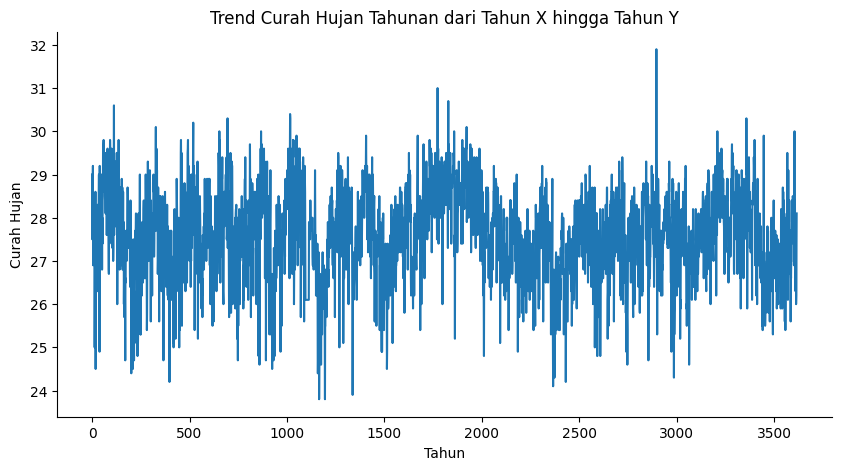

In [6]:
# Plot data RR dengan judul yang lebih deskriptif
data['Tavg'].plot(kind='line', figsize=(10, 5), title='Trend Curah Hujan Tahunan dari Tahun X hingga Tahun Y')
plt.gca().spines[['top', 'right']].set_visible(False)  # Sembunyikan spines atas dan kanan
plt.xlabel('Tahun')  # Label sumbu X
plt.ylabel('Curah Hujan')  # Label sumbu Y
plt.show()

## LSTM

In [7]:
# Model LSTM
scaler = StandardScaler()
data_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

In [8]:
# Membagi data training dan testing
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[0:train_size, :], data_scaled[train_size:len(data_scaled), :]

In [9]:
# Fungsi untuk membuat dataset dengan time steps
def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

In [10]:
# Membuat dataset dengan time steps
time_steps = 7
# Assuming num_features is 1 for a univariate time series
num_features = 1
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

In [11]:
# Reshape data untuk LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [12]:
# Membuat model LSTM
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(time_steps, num_features)))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - loss: 0.7920 - val_loss: 0.6058
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.6553 - val_loss: 0.5483
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.6216 - val_loss: 0.5468
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.6283 - val_loss: 0.5479
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6031 - val_loss: 0.5476
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.6312 - val_loss: 0.5468
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.6193 - val_loss: 0.5555
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6088 - val_loss: 0.5382
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.6581 - val_loss: 0.5646
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.5964 - val_loss: 0.5537
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.6294 - val_loss: 0.5582
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/ste

In [14]:
# Prediksi menggunakan model LSTM
predicted_values_lstm = model.predict(X_test)
predicted_values_lstm = scaler.inverse_transform(predicted_values_lstm)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


In [15]:
# Evaluate Model LSTM
actual_values_lstm = y[-len(predicted_values_lstm):].values  # Convert to NumPy array

# Ensure both actual and predicted values have the same length
if len(actual_values_lstm) != len(predicted_values_lstm):
    print("Length mismatch between actual and predicted values.")
else:
    # Calculate metrics
    metrics_lstm = calculate_metrics(actual_values_lstm, predicted_values_lstm)
    print("\nMetrics Evaluation for LSTM Model:")
    print(metrics_lstm)


Metrics Evaluation for LSTM Model:
{'MAE': 0.5671227538934811, 'MSE': 0.54762612749204, 'RMSE': np.float64(0.7400176535002662), 'R2': 0.3653870841621979}


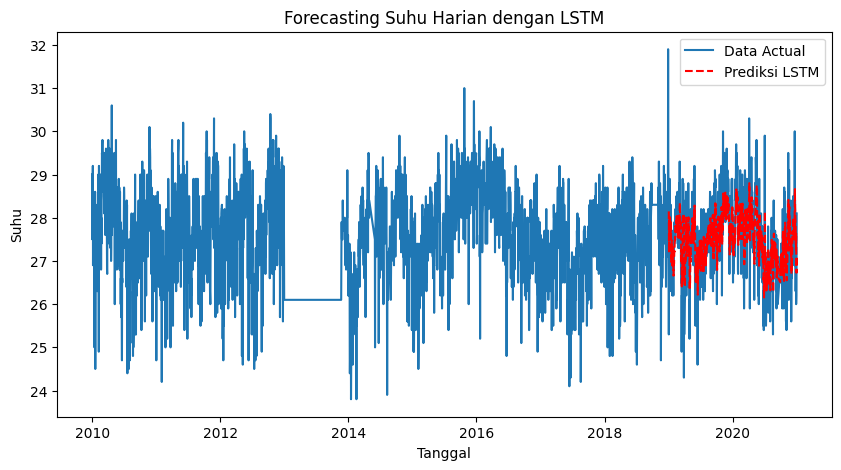

In [16]:
# Visualisasi Forecasting dengan LSTM
plt.figure(figsize=(10, 5))
# Adjust the indices for plotting
plt.plot(data['date'], data['Tavg'], label='Data Actual')
plt.plot(data['date'].tail(len(predicted_values_lstm)), predicted_values_lstm.flatten(), label='Prediksi LSTM', linestyle='dashed', color='red')
plt.title('Forecasting Suhu Harian dengan LSTM')
plt.xlabel('Tanggal')
plt.ylabel('Suhu')
plt.legend()
plt.show()


In [18]:
# Prediksi untuk beberapa hari ke depan dengan LSTM
days_to_predict = 15
last_data = np.array([test_data[-1]])
predicted_values_future = []

for i in range(days_to_predict):
    prediction = model.predict(np.reshape(last_data, (1, 1, 1)))
    last_data = np.array([prediction])
    prediction_inverse = scaler.inverse_transform(prediction)
    predicted_values_future.append(prediction_inverse[0, 0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


In [20]:
# Inverse transform the future predictions
predicted_values_future = scaler.inverse_transform(np.array(predicted_values_future).reshape(-1, 1))

# Membuat dataframe hasil prediksi
date_future = pd.date_range(start=data['date'].max() + pd.to_timedelta(1, unit='D'), periods=days_to_predict)
future_df = pd.DataFrame({'Year': date_future, 'Predicted_Price': predicted_values_future.flatten()})

# Menampilkan dataframe hasil prediksi
print("\nHasil Prediksi Suhu untuk 30 Hari ke Depan:")
print(future_df)


Hasil Prediksi Suhu untuk 30 Hari ke Depan:
         Year  Predicted_Price
0  2021-01-01        85.723251
1  2021-01-02        85.580086
2  2021-01-03        85.522957
3  2021-01-04        85.500275
4  2021-01-05        85.491280
5  2021-01-06        85.487717
6  2021-01-07        85.486313
7  2021-01-08        85.485756
8  2021-01-09        85.485535
9  2021-01-10        85.485451
10 2021-01-11        85.485413
11 2021-01-12        85.485397
12 2021-01-13        85.485390
13 2021-01-14        85.485390
14 2021-01-15        85.485390
